# Distributions

## Funnel

In [ ]:
import numpy as np
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
    """
    def __init__(self, num_dims=2):
        self.num_dims = num_dims
        self.normal_first = Normal(0, 1)

    @property
    def dim(self) -> int:
        return self.num_dims

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        normal_last = Normal(torch.zeros(x.shape[:-1], device=x.device), torch.exp(x[..., 0] / 2.))
        return normal_last.log_prob(x[..., 1:].permute(-1, *range(x.ndim-1))).sum(0) + self.normal_first.log_prob(x[..., 0])

    def likelihood(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            p(x)
        """
        return torch.exp(self.log_prob(x))

    def plot_2d_countour(self, ax):
        """
        Visualizes contour plot of Funnel distribution using log p(x)
        """
        x = np.linspace(-15, 15, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        ax.contour(Y, X, Z.exp(),
                   levels=3,
                   alpha=1., colors='midnightblue', linewidths=1)

    def visualize_dist(self, s=10000):
        """
        Visualizes Funnel distribution using sampled points
        """
        # Generate points from funnel distribution
        points = np.transpose(self.sample(s))
        Y = points[0]
        X = points[1]

        # Calculate the point density
        XY = np.vstack([X,Y])
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        plt.scatter(X, Y, c=Z, label=Z)
        plt.colorbar()
        plt.show()
        plt.close()

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Sample from the Funnel distribution
        """
        all_c = torch.randn((num_samples, self.dim))
        all_c[:, 0] = all_c[:, 0] * 1**0.5
        all_c[:, 1:] = all_c[:, 1:]*(torch.exp(1*all_c[:, 0]))[:, None]
        return all_c

    def estimate_dist(self, s=100000):
        """
        Estimates mean and standard deviation of the Funnel distribution
        by sampling from it
        """
        target_samp = self.sample(s)
        std = torch.std(target_samp, dim=0).numpy()
        m = torch.mean(target_samp, dim=0).numpy()
        return [m, std]

In [ ]:
funnel = Funnel(num_dims=2)

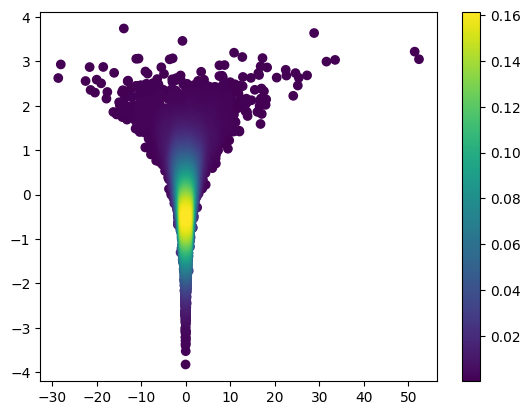

In [ ]:
funnel.visualize_dist(s=10000)

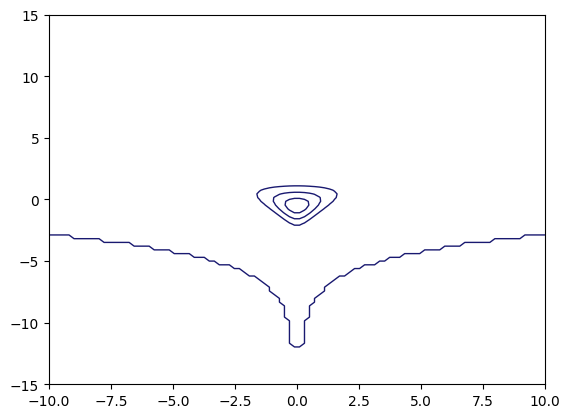

In [ ]:
ax = plt.subplot()
funnel.plot_2d_countour(ax)

In [ ]:
x = torch.tensor([[1.0, 0.5], [-1.0, -0.5]], dtype=torch.float32)

likelihoods = funnel.likelihood(x)
print(f"Likelihoods: {likelihoods}")

logprobs = funnel.log_prob(x)
print(f"Log probs: {logprobs}")

Likelihoods: tensor([0.0559, 0.1133])
Log probs: tensor([-2.8839, -2.1777])


In [ ]:
print("Means by dimensions: ", funnel.estimate_dist(s=1000000)[0])
print("Std by dimensions: ", funnel.estimate_dist(s=1000000)[1])

Means by dimensions:  [ 0.00021417 -0.00147417]
Std by dimensions:  [1.0004513 2.7675061]


## Banana

In [ ]:
import numpy as np
import torch
import torch.distributions as D
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

class Banana:

    def __init__(self, b=0.02, dim=2):
        self.b = b
        self.dim = dim
        self.sigma = 10 # can be changed

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        even = np.arange(0, x.shape[-1], 2)
        odd = np.arange(1, x.shape[-1], 2)
        ll = -0.5 * (x[..., odd] - self.b * x[..., even]**2 + (self.sigma**2) * self.b)**2 - ((x[..., even])**2)/(2 * self.sigma**2)
        return ll.sum(-1)

    def likelihood(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            p(x)
        """
        return torch.exp(self.log_prob(x))

    def sample(self, s):
        """
        Sample from the Banana distribution
        """
        torch.manual_seed(926)
        even = np.arange(0, self.dim, 2)
        odd = np.arange(1, self.dim, 2)
        var = torch.ones(self.dim)
        var[..., even] = self.sigma**2
        base_dist = D.MultivariateNormal(torch.zeros(self.dim), torch.diag(var))
        samples = base_dist.sample((s,))
        samples[..., odd] += self.b * samples[..., even]**2 - self.b * self.sigma**2
        return samples

    def plot_2d_countour(self, ax):
        """
        Visualizes contour plot of Banana distribution using log p(x)
        """
        x = np.linspace(-20, 20, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        ax.contour(X, Y, Z.exp(),
                   levels=5,
                   alpha=1., colors='midnightblue', linewidths=1)

    def visualize_dist(self, s=1000):
        """
        Visualizes Banana distribution using sampled points
        """
        # Generate points from distribution
        points = self.sample(s)
        X = points[:, 0]
        Y = points[:, 1]

        # Calculate the point density
        XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
        Z = gaussian_kde(XY)(XY)

        # Sort the points by density, so that the densest points are plotted last
        idx = Z.argsort()
        X, Y, Z = X[idx], Y[idx], Z[idx]

        plt.scatter(X, Y, c=Z, label=Z)
        plt.colorbar()
        plt.show()
        plt.close()

    def estimate_dist(self, s=10000000):
        """
        Estimates mean and standard deviation of the Banana distribution
        by sampling from it
        """
        target_samp = self.sample(s)
        std = torch.std(target_samp, dim=0).numpy()
        m = torch.mean(target_samp, dim=0).numpy()
        return [m, std]

In [ ]:
banana = Banana(b=0.02, dim=4)

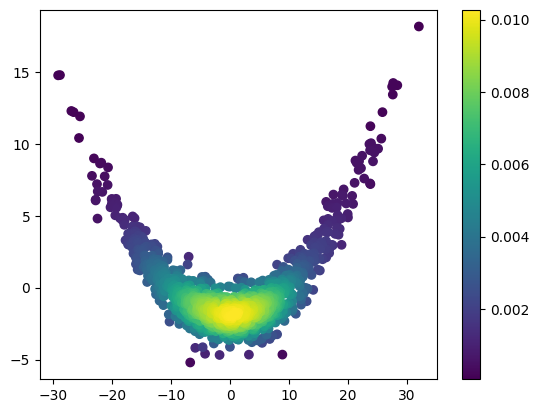

In [ ]:
banana.visualize_dist()

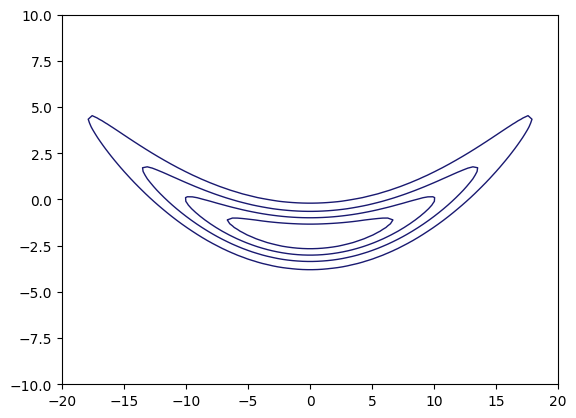

In [ ]:
ax = plt.subplot()
banana.plot_2d_countour(ax)

In [ ]:
x = torch.tensor([[1.0, 0.5, 1.0, 0.5], [-1.0, -0.5, -1.0, -0.5]], dtype=torch.float32)

likelihoods = banana.likelihood(x)
print(f"Likelihoods: {likelihoods}")

logprobs =  banana.log_prob(x)
print(f"Log probs: {logprobs}")

Likelihoods: tensor([0.0021, 0.1108])
Log probs: tensor([-6.1604, -2.2004])


In [ ]:
print("Means by dimensions: ", banana.estimate_dist(s=1000000)[0])
print("Std by dimensions: ", banana.estimate_dist(s=1000000)[1])

Means by dimensions:  [-0.00779778  0.00095925  0.00921663  0.00329735]
Std by dimensions:  [10.000041   3.0079267 10.007578   3.0057628]
